# Description
The notations of the parameters used in this notebook are as followed:
- raw_df      = imported dataset
- data        = gathered samples
- target      = labels regarding each data
- scaled_data = Standardized data
- x_train     = data used for training the model
- y_train     = targets used for training the model
- x_test      = data used to test the model
- y_test      = targets used to test the model
- y_pred      = predicted targets by the model

# Parameter Selection

In [1]:
dataset_sel = 3   
# 0 for Boston Housing Price
# 1 for California Housing Price
# 2 for Tehran Housing Price
# 3 for Fuel Consumption

PairPlot = 0 # enable to visualize Pair-Plot
data_normalization = 1 # enable to normalize the raw data
outliers_removal = 1 # enable to remove the outliers
reg_model = 0
# 0 for Ridge Regression using Scikit-Learn 

import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

# Load Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Load Dataset and Primary Data Preparation

In [3]:
if dataset_sel == 0:
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df_tmp = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df_tmp.values[::2, :], raw_df_tmp.values[1::2, :2]])
    raw_df = pd.DataFrame(data, columns=['Crime','ZN','INDUS','CHAS','nitric oxides','Rooms','Age','Distance','Accesibility','Tax','pupil-teacher','B',
                                         'Lower status'])
    raw_df["Price"]=raw_df_tmp.values[1::2, 2]
    data_end_index=-2
    target=raw_df.iloc[:,-1]
elif dataset_sel == 1:
    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()
    raw_df = pd.DataFrame(housing.data, columns=['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'])
    raw_df["Price"]=housing.target
    data_end_index=-2
    target=raw_df.iloc[:,-1]
elif dataset_sel == 2: 
    # dataset from github of Prof. Sharifzarchi
    data_url = 'https://github.com/mghadian/Machine-Learning/raw/main/housePrice.xlsx'
    raw_df_tmp = pd.read_excel(data_url, engine='openpyxl')
    raw_df_tmp = raw_df_tmp.drop('Price',axis=1)
    ## One Hot Encoding
    raw_df_tmp=pd.get_dummies(raw_df_tmp)
    column_to_move = 'PriceUSD'
    cols = [col for col in raw_df_tmp.columns if col != column_to_move] + [column_to_move]
    raw_df = raw_df_tmp.reindex(columns=cols)
    raw_df.iloc[:,-1] = raw_df.iloc[:,-1]*0.001
    data_end_index=-2
    target=raw_df.iloc[:,-1]
elif dataset_sel == 3:
    data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"
    raw_df_tmp = pd.read_csv(data_url)
    raw_df_tmp=pd.get_dummies(raw_df_tmp)
    column_to_move = ['FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB','FUELCONSUMPTION_COMB_MPG','CO2EMISSIONS']
    cols = [col for col in raw_df_tmp.columns if col not in column_to_move] + column_to_move
    raw_df = raw_df_tmp.reindex(columns=cols)
    data_end_index=-6
    target=raw_df.iloc[:,-5:]

# Data Preparation

## Data Normalization

In [4]:
if data_normalization == 1:
    zero_array = np.zeros((raw_df.shape[0],raw_df.shape[1]+data_end_index+1))
    scaled_data = pd.DataFrame(zero_array,columns=raw_df.columns[:data_end_index+1])
    for i in range(raw_df.shape[1]+data_end_index):
        if raw_df.iloc[:,i].std() != 0:
            if isinstance(raw_df.iloc[0,i], np.int64) and not isinstance(raw_df.iloc[0,i], bool):
                scaled_data.iloc[:,i] = (raw_df.iloc[:,i] - raw_df.iloc[:,i].mean()) / raw_df.iloc[:,i].std()
            else:
                scaled_data.iloc[:,i] = raw_df.iloc[:,i] 
        else:
            scaled_data.iloc[:,i] = raw_df.iloc[:,i]
else:
    scaled_data = raw_df.iloc[:,:data_end_index+1]

## Outliers Removal

In [6]:
if outliers_removal == 1:
    for i in range(scaled_data.shape[1]):
        if isinstance(scaled_data.iloc[0, i], (int, float, np.int64)) and not isinstance(scaled_data.iloc[0, i], bool):
            # Data cleaning - removing outliers based on IQR
            Q1_i = scaled_data.iloc[:,i].quantile(0.25)
            Q3_i = scaled_data.iloc[:,i].quantile(0.75)
            IQR_area = Q3_i - Q1_i
            
            lower_bound = Q1_i - 1.5 * IQR_area
            upper_bound = Q3_i + 1.5 * IQR_area
            
            scaled_data_tmp = scaled_data[(scaled_data.iloc[:,i] >= lower_bound) & (scaled_data.iloc[:,i] <= upper_bound)]
            target = target[(scaled_data.iloc[:,i] >= lower_bound) & (scaled_data.iloc[:,i] <= upper_bound)]
            scaled_data = scaled_data_tmp

# Visualization

In [7]:
scaled_data

,MODELYEAR,ENGINESIZE,CYLINDERS,MAKE_ACURA,MAKE_ASTON MARTIN,MAKE_AUDI,MAKE_BENTLEY,MAKE_BMW,MAKE_BUICK,MAKE_CADILLAC,...,TRANSMISSION_AV6,TRANSMISSION_AV7,TRANSMISSION_AV8,TRANSMISSION_M5,TRANSMISSION_M6,TRANSMISSION_M7,FUELTYPE_D,FUELTYPE_E,FUELTYPE_X,FUELTYPE_Z
0,2014.0,2.0,-0.998500,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.0
1,2014.0,2.4,-0.998500,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0.0
2,2014.0,1.5,-0.998500,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,0.0
3,2014.0,3.5,0.114189,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.0
4,2014.0,3.5,0.114189,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062,2014.0,3.0,0.114189,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0.0
1063,2014.0,3.2,0.114189,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0.0
1064,2014.0,3.0,0.114189,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0.0
1065,2014.0,3.2,0.114189,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0.0


In [16]:
target

,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,9.9,6.7,8.5,33,196
1,11.2,7.7,9.6,29,221
2,6.0,5.8,5.9,48,136
3,12.7,9.1,11.1,25,255
4,12.1,8.7,10.6,27,244
...,...,...,...,...,...
1062,13.4,9.8,11.8,24,271
1063,13.2,9.5,11.5,25,264
1064,13.4,9.8,11.8,24,271
1065,12.9,9.3,11.3,25,260


In [8]:
if PairPlot == 1:
    import seaborn as sns
    sns.pairplot(scaled_data)

## Principal Component Analysis

Explained Variance Ratio Using PCA is:  [0.41883548 0.04698067]


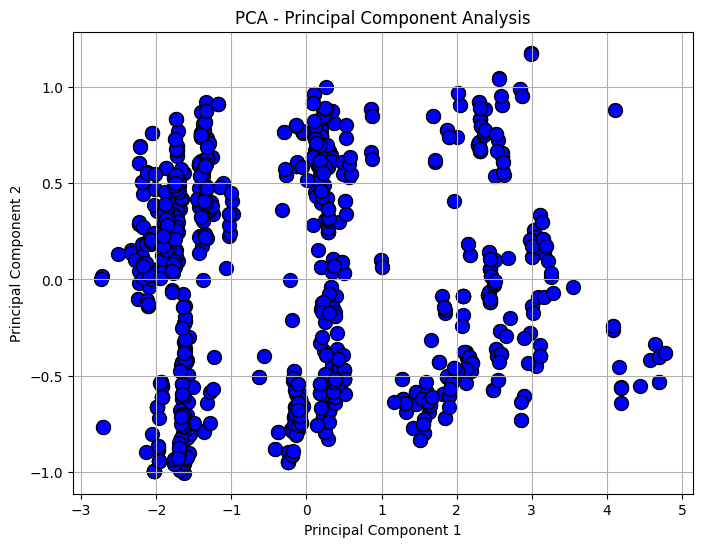

In [10]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=data_pca, columns=['PC1', 'PC2'])
print('Explained Variance Ratio Using PCA is: ',pca.explained_variance_ratio_)
# Visualizing the principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', edgecolor='k', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - Principal Component Analysis')
plt.grid(True)
plt.show()

# Creation of Training & Test Data

In [11]:
x_train,x_test,y_train,y_test=train_test_split(scaled_data,target,test_size=0.3, random_state=42)

# Regression

## Regression Using SK-Learn

In [12]:
# Function to generate polynomial features (input matrix X')
def polynomial_features(X, degree):
    X_poly = np.c_[np.ones(len(X))]
    for i in range(1, degree + 1):
        X_poly = np.c_[X_poly, X**i]
    return X_poly

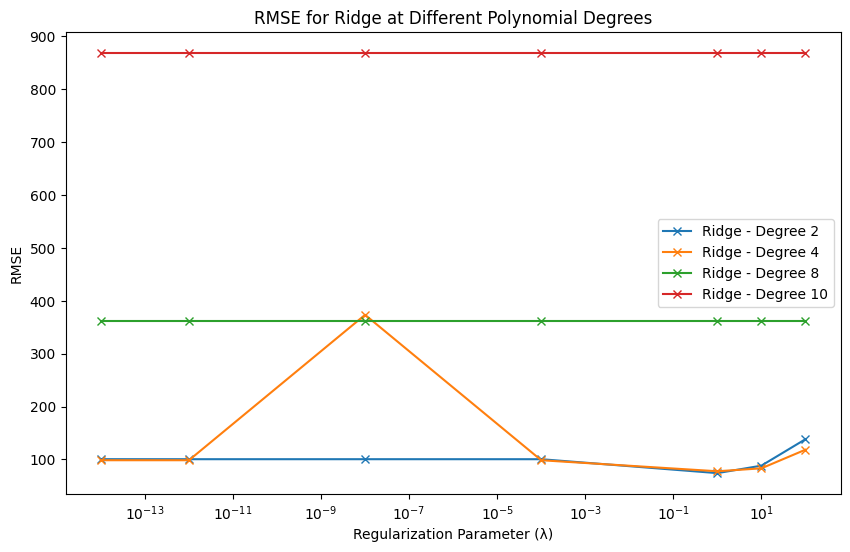

In [13]:
if reg_model == 0:
    degrees = [2, 4, 8, 10]
    lambdas = [100, 10, 1, 1e-4, 1e-8, 1e-12, 1e-14]
    ridge_rmse_train = np.zeros((len(degrees), len(lambdas)))
    ridge_rmse_test = np.zeros((len(degrees), len(lambdas)))
    
    for degree_idx, degree in enumerate(degrees):
        for lambda_idx, lambda_val in enumerate(lambdas):
            x_train_poly = polynomial_features(x_train,degree)
            x_test_poly = polynomial_features(x_test,degree)

            ridge_model = Ridge(alpha=lambda_val)
            ridge_model.fit(x_train_poly, y_train)
            y_train_pred_ridge = ridge_model.predict(x_train_poly)
            y_test_pred_ridge = ridge_model.predict(x_test_poly)
    
            ridge_rmse_train[degree_idx, lambda_idx] = mean_squared_error(y_train, y_train_pred_ridge)
            ridge_rmse_test[degree_idx, lambda_idx] = mean_squared_error(y_test, y_test_pred_ridge)
    
    # plot RMSE
    plt.figure(figsize=(10, 6))
    
    for degree_idx, degree in enumerate(degrees):
        plt.plot(lambdas, ridge_rmse_test[degree_idx], marker='x', label=f'Ridge - Degree {degree}')
    plt.xscale('log')
    plt.xlabel('Regularization Parameter (λ)')
    plt.ylabel('RMSE')
    plt.title('RMSE for Ridge at Different Polynomial Degrees')
    plt.legend()
    plt.show()
    
    m = np.unravel_index(np.argmin(ridge_rmse_test), ridge_rmse_test.shape)
    
    x_train_poly = polynomial_features(x_train,degrees[int(m[0])])
    x_test_poly = polynomial_features(x_test,degrees[int(m[0])])
    ridge_model = Ridge(alpha=lambdas[int(m[1])])
    ridge_model.fit(x_train_poly, y_train)
    y_pred = ridge_model.predict(x_test_poly)

# Performance Analysis

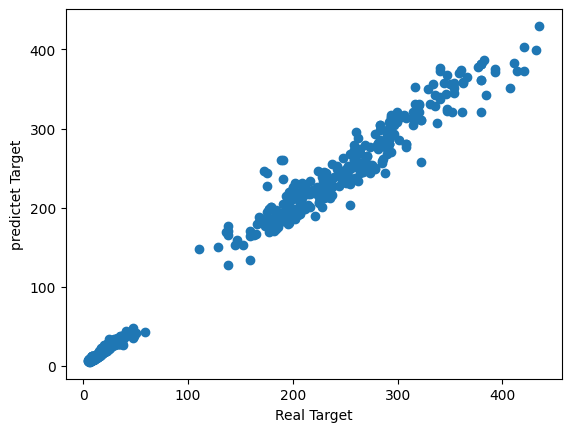

Regresion MSE is:  74.0753919091513


In [14]:
    plt.scatter(y_test,y_pred)
    plt.xlabel('Real Target')
    plt.ylabel('predictet Target')
    plt.show()
    mse=mean_squared_error(y_test,y_pred)
    print("Regresion MSE is: ", mse)